[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train YOLO Object Detection on a Custom Dataset

---


## Environment setup

In [1]:
import os
from dotenv import load_dotenv

load_dotenv()  # charge .env dans os.environ
api_key = os.getenv("ROBOFLOW_API_KEY")

### Check GPU availability

In [42]:
!nvidia-smi

Fri Jun  6 11:07:09 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   59C    P0             30W /   70W |     888MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [1]:
import os
HOME = os.getcwd()
print(HOME)

/home/jovyan/notebooks


### Install dependencies

In [2]:
!pip install roboflow supervision opencv-python ultralytics

Defaulting to user installation because normal site-packages is not writeable


### Download example data


In [3]:
!wget https://github.com/laurent-pereira/ia-face-detector/blob/master/example.jpg?raw=true

--2025-06-21 10:16:55--  https://github.com/laurent-pereira/ia-face-detector/blob/master/example.jpg?raw=true
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/laurent-pereira/ia-face-detector/raw/refs/heads/master/example.jpg [following]
--2025-06-21 10:16:55--  https://github.com/laurent-pereira/ia-face-detector/raw/refs/heads/master/example.jpg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/laurent-pereira/ia-face-detector/refs/heads/master/example.jpg [following]
--2025-06-21 10:16:56--  https://raw.githubusercontent.com/laurent-pereira/ia-face-detector/refs/heads/master/example.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (

## Run inference


WARNING ⚠️ user config directory '/home/jovyan/.config/Ultralytics' is not writeable, defaulting to '/tmp' or CWD.Alternatively you can define a YOLO_CONFIG_DIR environment variable for this path.
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/tmp/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


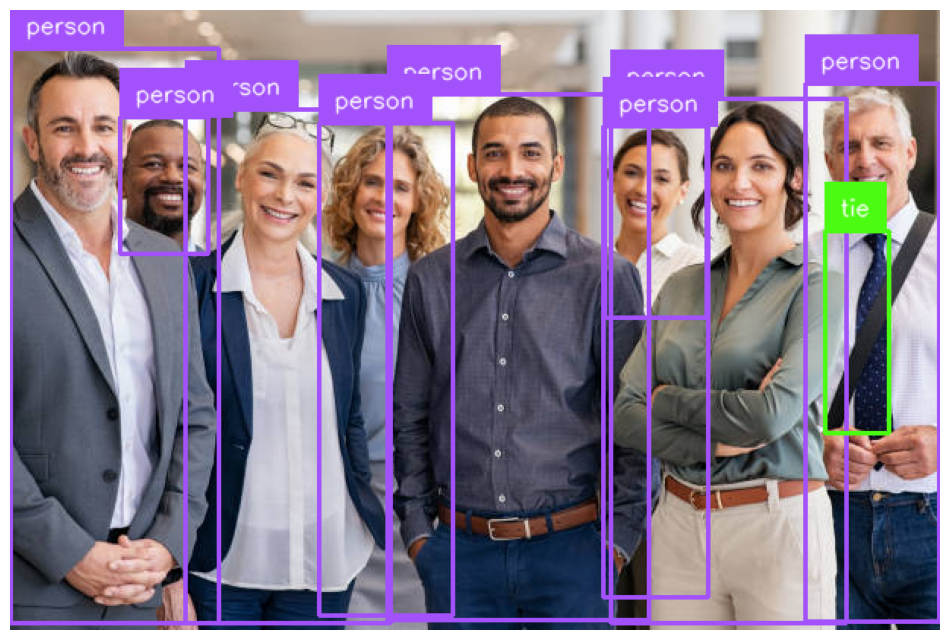

In [4]:
import cv2
from ultralytics import YOLO
import supervision as sv


image_path = f"{HOME}/example.jpg?raw=true"
image = cv2.imread(image_path)

model = YOLO('yolov8m.pt')

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results)

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

## Download dataset from Roboflow Universe

In [4]:
!pip install roboflow


import getpass
from roboflow import Roboflow

api_key = getpass.getpass("Entre ta clé API Roboflow (masquée) : ")

rf = Roboflow(api_key=api_key)
project = rf.workspace("mohamed-traore-2ekkp").project("face-detection-mik1i")
version = project.version(27)
dataset = version.download("yolov8")

Defaulting to user installation because normal site-packages is not writeable


Entre ta clé API Roboflow (masquée) :  ········


loading Roboflow workspace...
loading Roboflow project...


In [6]:
!ls {dataset.location}

README.dataset.txt  README.roboflow.txt  data.yaml  test  train  valid


**NOTE:** We need to make a few changes to our downloaded dataset. Run the following bash commands to prepare your dataset for training by updating the relative paths in the `data.yaml` file, ensuring it correctly points to the subdirectories for your dataset's `train`, `test`, and `valid` subsets.

In [7]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

In [8]:
!cat {dataset.location}/data.yaml

names:
- face
nc: 1
roboflow:
  license: CC BY 4.0
  project: face-detection-mik1i
-e test: ../test/images
train: ../train/images
val: ../valid/images


## Fine-tune YOLO model


In [30]:
from ultralytics import YOLO

model = YOLO('yolov8m')

results = model.train(data=f'{dataset.location}/data.yaml',  project='/home/jovyan/yolo-training', epochs=25, batch=1, patience=0, save_period=5, save=True, workers=2)

Ultralytics 8.3.157 🚀 Python-3.10.18 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce GTX 1060 3GB, 3072MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/jovyan/notebooks/Face-Detection-27/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train5, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=0, perspective=

train: Scanning /home/jovyan/notebooks/Face-Detection-27/train/labels.cache... 132 images, 9 backgrounds, 0 corrupt: 100% 132/132 [00:00<?, ?it/s]


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 84.8±13.9 MB/s, size: 88.6 KB)


val: Scanning /home/jovyan/notebooks/Face-Detection-27/valid/labels.cache... 38 images, 1 backgrounds, 0 corrupt: 100% 38/38 [00:00<?, ?it/s]


Plotting labels to /home/jovyan/yolo-training/train5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /home/jovyan/yolo-training/train5
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      2.94G      1.259      2.534      1.559          6        640: 100% 132/132 [02:13<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 19/19 [00:05<00:00,  3.28it/s]


                   all         38         49      0.405      0.796      0.507      0.267

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      1.79G      1.287      2.729      1.407          2        640: 100% 132/132 [00:34<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 19/19 [00:02<00:00,  9.18it/s]

                   all         38         49      0.768      0.714      0.794      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      1.79G       1.46      2.772      1.603          2        640: 100% 132/132 [00:34<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 19/19 [00:01<00:00,  9.95it/s]

                   all         38         49       0.43      0.592      0.551      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25       1.8G      1.937      2.627      1.941          4        640: 100% 132/132 [00:35<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 19/19 [00:01<00:00, 10.01it/s]

                   all         38         49     0.0137      0.633     0.0126    0.00305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      1.76G      1.648      3.166      1.747          1        640: 100% 132/132 [00:34<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 19/19 [00:01<00:00,  9.73it/s]

                   all         38         49    0.00938      0.102    0.00443    0.00151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25       1.8G      1.716      2.622      1.654          2        640: 100% 132/132 [00:35<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 19/19 [00:02<00:00,  9.47it/s]

                   all         38         49      0.193      0.306      0.166     0.0668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      1.76G      1.667      2.122      1.705          2        640: 100% 132/132 [00:34<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 19/19 [00:02<00:00,  8.26it/s]

                   all         38         49     0.0816      0.265     0.0372     0.0148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      1.77G      1.489      2.001      1.664          2        640: 100% 132/132 [00:35<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 19/19 [00:02<00:00,  9.26it/s]


                   all         38         49     0.0174      0.469     0.0169    0.00736

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      1.79G      1.372      1.832       1.55          1        640: 100% 132/132 [00:34<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 19/19 [00:01<00:00,  9.55it/s]

                   all         38         49      0.067      0.245     0.0421     0.0177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      1.76G       1.31       1.49      1.411          1        640: 100% 132/132 [00:35<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 19/19 [00:02<00:00,  9.36it/s]

                   all         38         49     0.0392      0.735     0.0365     0.0199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      1.76G      1.326      1.362       1.44          1        640: 100% 132/132 [00:34<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 19/19 [00:01<00:00,  9.94it/s]

                   all         38         49     0.0141      0.551      0.012    0.00642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      1.77G      1.359      1.386      1.504          3        640: 100% 132/132 [00:35<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 19/19 [00:02<00:00,  9.03it/s]

                   all         38         49      0.621      0.694      0.593      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      1.76G      1.307      1.334      1.456          1        640: 100% 132/132 [00:35<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 19/19 [00:02<00:00,  9.09it/s]

                   all         38         49      0.289      0.694      0.361      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      1.77G      1.215      1.223      1.351          1        640: 100% 132/132 [00:36<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 19/19 [00:01<00:00,  9.58it/s]

                   all         38         49      0.642      0.796      0.723      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      1.79G      1.213      1.214      1.323          1        640: 100% 132/132 [00:36<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 19/19 [00:02<00:00,  9.37it/s]

                   all         38         49      0.473      0.697      0.615      0.361


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      1.79G      1.126      1.087      1.283          3        640: 100% 132/132 [00:36<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 19/19 [00:02<00:00,  8.40it/s]

                   all         38         49      0.238      0.571      0.233      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      1.79G      1.012     0.9737      1.207          2        640: 100% 132/132 [00:35<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 19/19 [00:02<00:00,  8.51it/s]

                   all         38         49      0.117      0.776      0.111     0.0698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      1.79G      1.046     0.9777      1.299          2        640: 100% 132/132 [00:36<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 19/19 [00:02<00:00,  9.25it/s]

                   all         38         49      0.158      0.714      0.141     0.0798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      1.79G      1.007     0.8985      1.227          1        640: 100% 132/132 [00:35<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 19/19 [00:02<00:00,  7.72it/s]

                   all         38         49      0.627      0.653      0.682      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      1.79G      1.072     0.9388      1.277          1        640: 100% 132/132 [00:38<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 19/19 [00:01<00:00,  9.55it/s]

                   all         38         49      0.715      0.633      0.632      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      1.79G     0.9538     0.8943      1.194          1        640: 100% 132/132 [00:36<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 19/19 [00:02<00:00,  8.89it/s]

                   all         38         49      0.911      0.837      0.886      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      1.77G     0.8972     0.8498      1.159          1        640: 100% 132/132 [00:35<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 19/19 [00:02<00:00,  9.02it/s]

                   all         38         49       0.84      0.878      0.904      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      1.79G     0.9236     0.8532      1.192          2        640: 100% 132/132 [00:36<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 19/19 [00:01<00:00,  9.89it/s]

                   all         38         49      0.741      0.714      0.746      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      1.77G     0.8851     0.8089      1.174          1        640: 100% 132/132 [00:36<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 19/19 [00:02<00:00,  9.50it/s]

                   all         38         49       0.95      0.774      0.906      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      1.79G     0.8325     0.7607      1.134          1        640: 100% 132/132 [00:37<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 19/19 [00:01<00:00,  9.55it/s]


                   all         38         49      0.955      0.867      0.934      0.603

25 epochs completed in 0.302 hours.
Optimizer stripped from /home/jovyan/yolo-training/train5/weights/last.pt, 52.0MB
Optimizer stripped from /home/jovyan/yolo-training/train5/weights/best.pt, 52.0MB

Validating /home/jovyan/yolo-training/train5/weights/best.pt...
Ultralytics 8.3.157 🚀 Python-3.10.18 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce GTX 1060 3GB, 3072MiB)
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 19/19 [00:01<00:00, 10.54it/s]


                   all         38         49      0.955      0.867      0.934      0.603
Speed: 1.0ms preprocess, 33.5ms inference, 0.0ms loss, 4.7ms postprocess per image
Results saved to /home/jovyan/yolo-training/train5


## Evaluate fine-tuned YOLOv12 model

In [31]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls /home/jovyan/yolo-training/train5

F1_curve.png			 labels_correlogram.jpg  train_batch2.jpg
PR_curve.png			 results.csv		 val_batch0_labels.jpg
P_curve.png			 results.png		 val_batch0_pred.jpg
R_curve.png			 train_batch0.jpg	 val_batch1_labels.jpg
args.yaml			 train_batch1.jpg	 val_batch1_pred.jpg
confusion_matrix.png		 train_batch1980.jpg	 val_batch2_labels.jpg
confusion_matrix_normalized.png  train_batch1981.jpg	 val_batch2_pred.jpg
labels.jpg			 train_batch1982.jpg	 weights


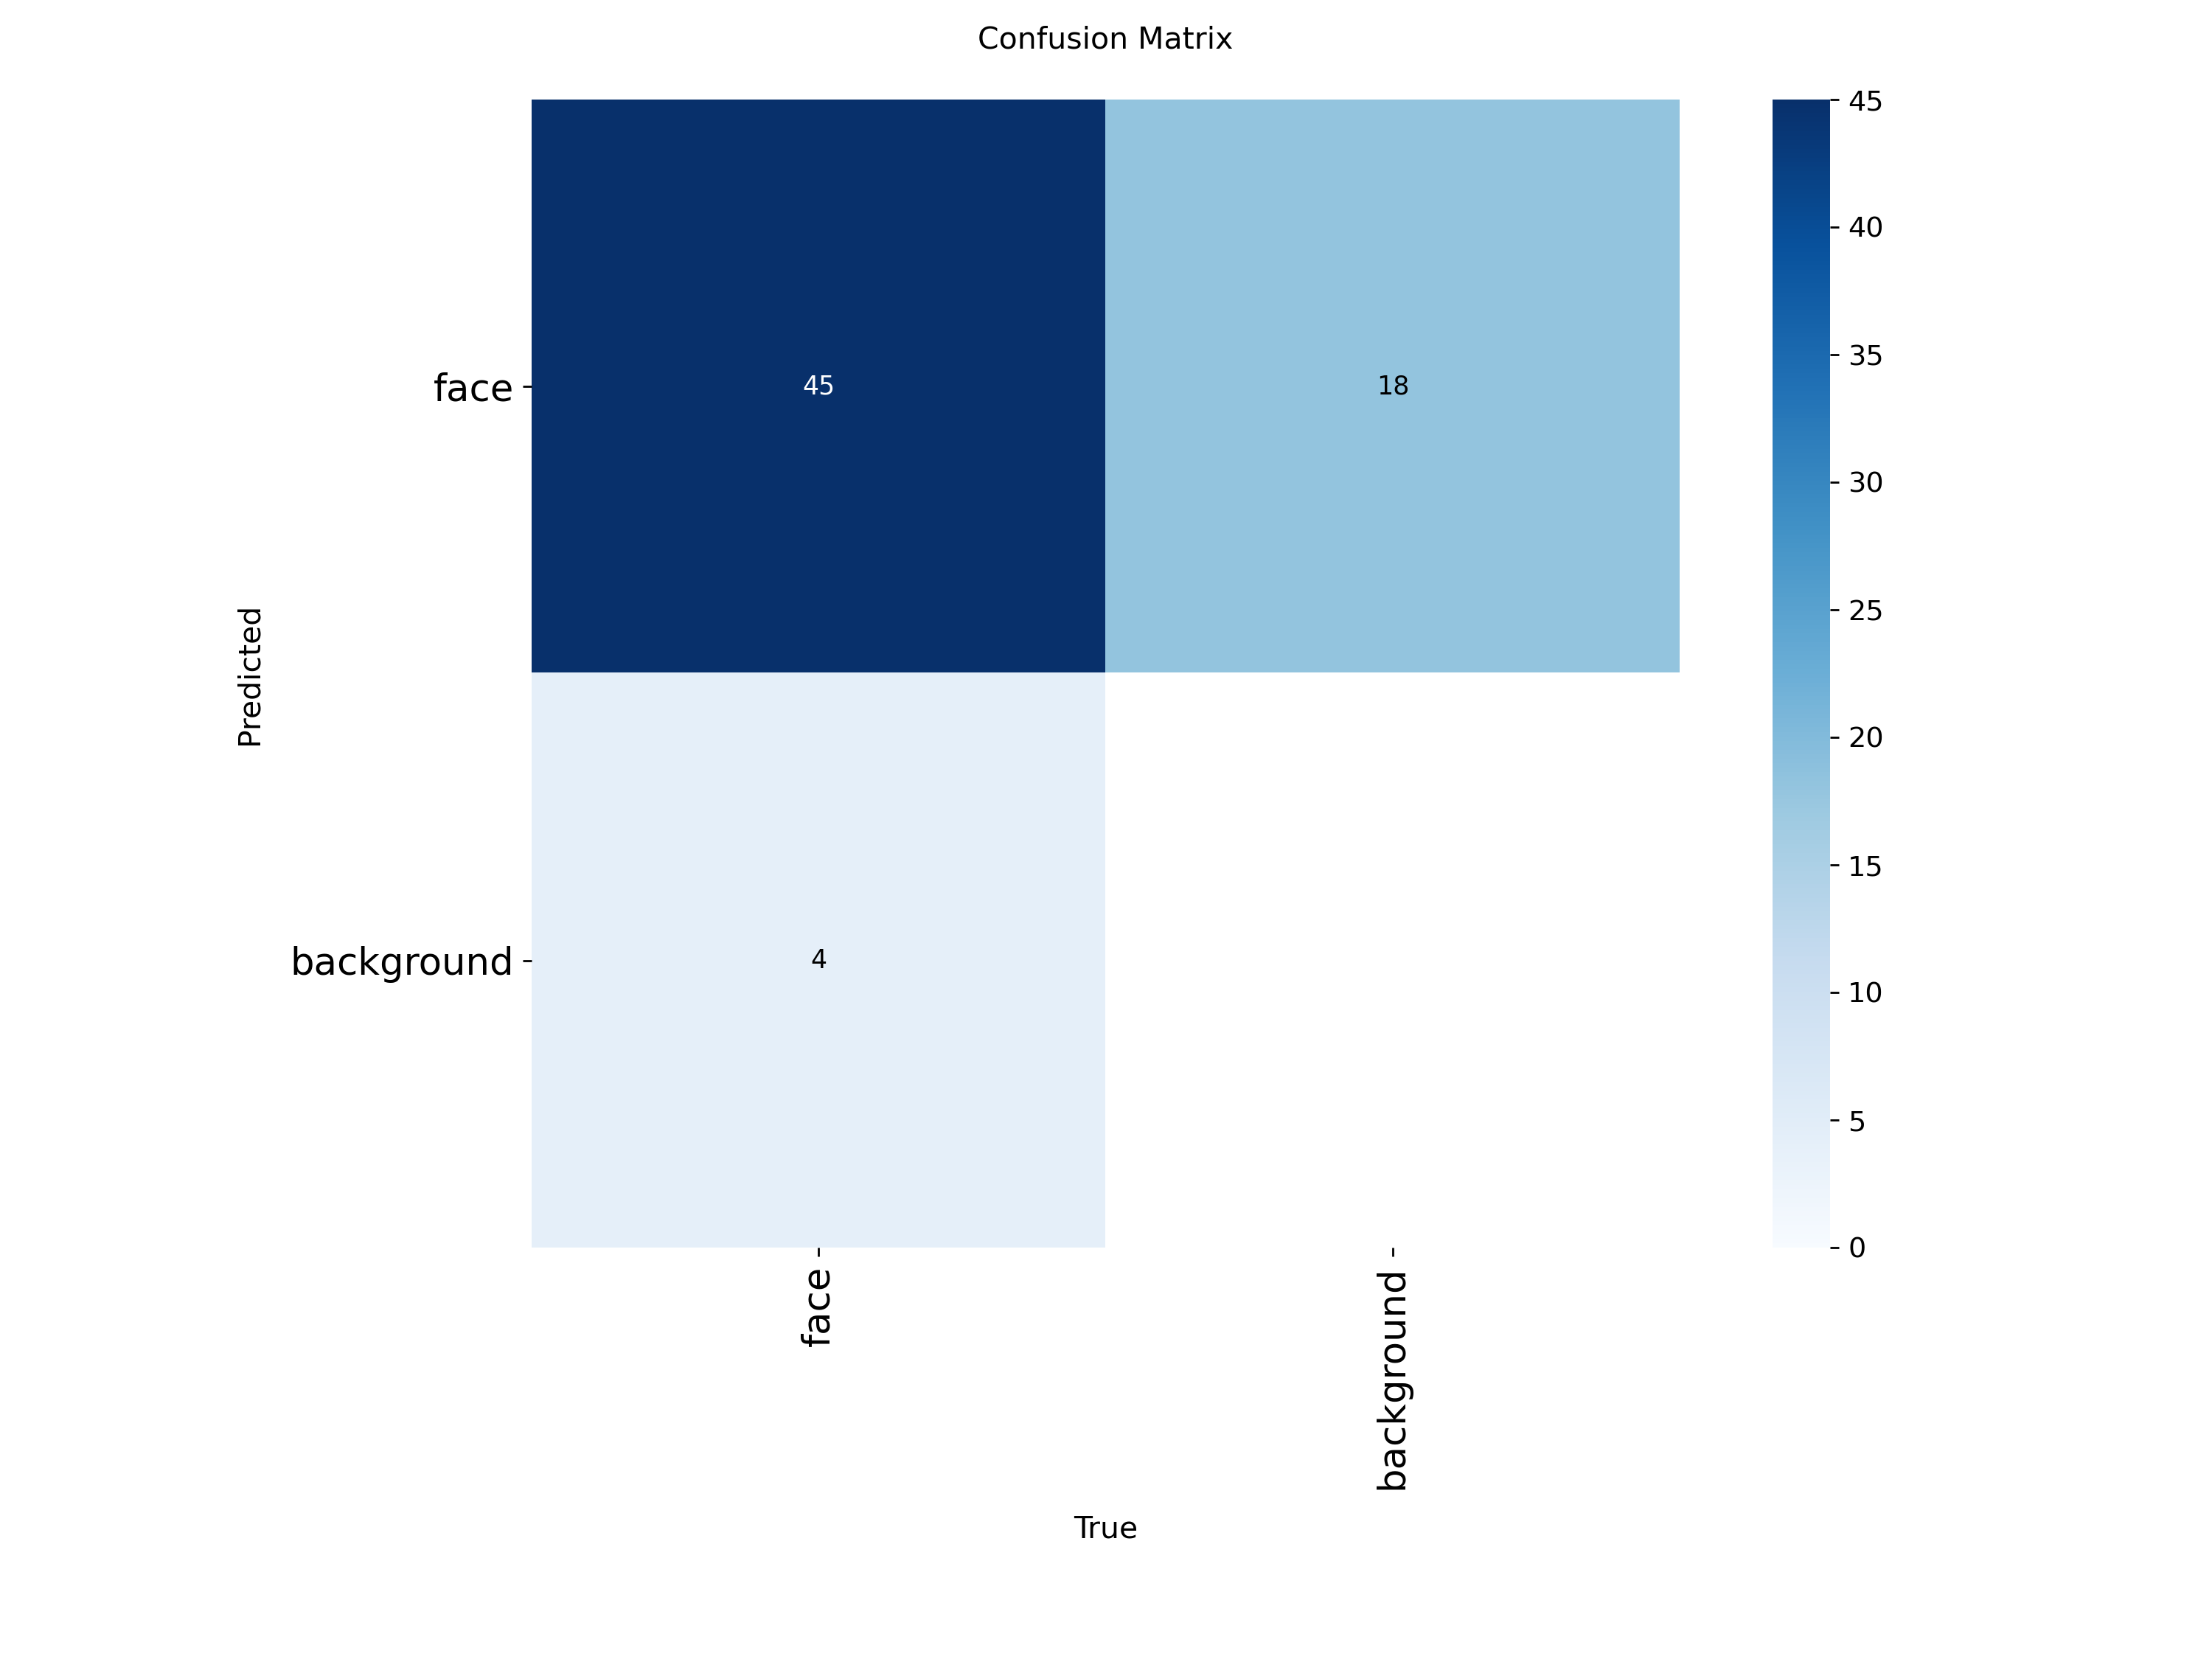

In [32]:
from IPython.display import Image

Image(filename=f'/home/jovyan/yolo-training/train5/confusion_matrix.png', width=1000)

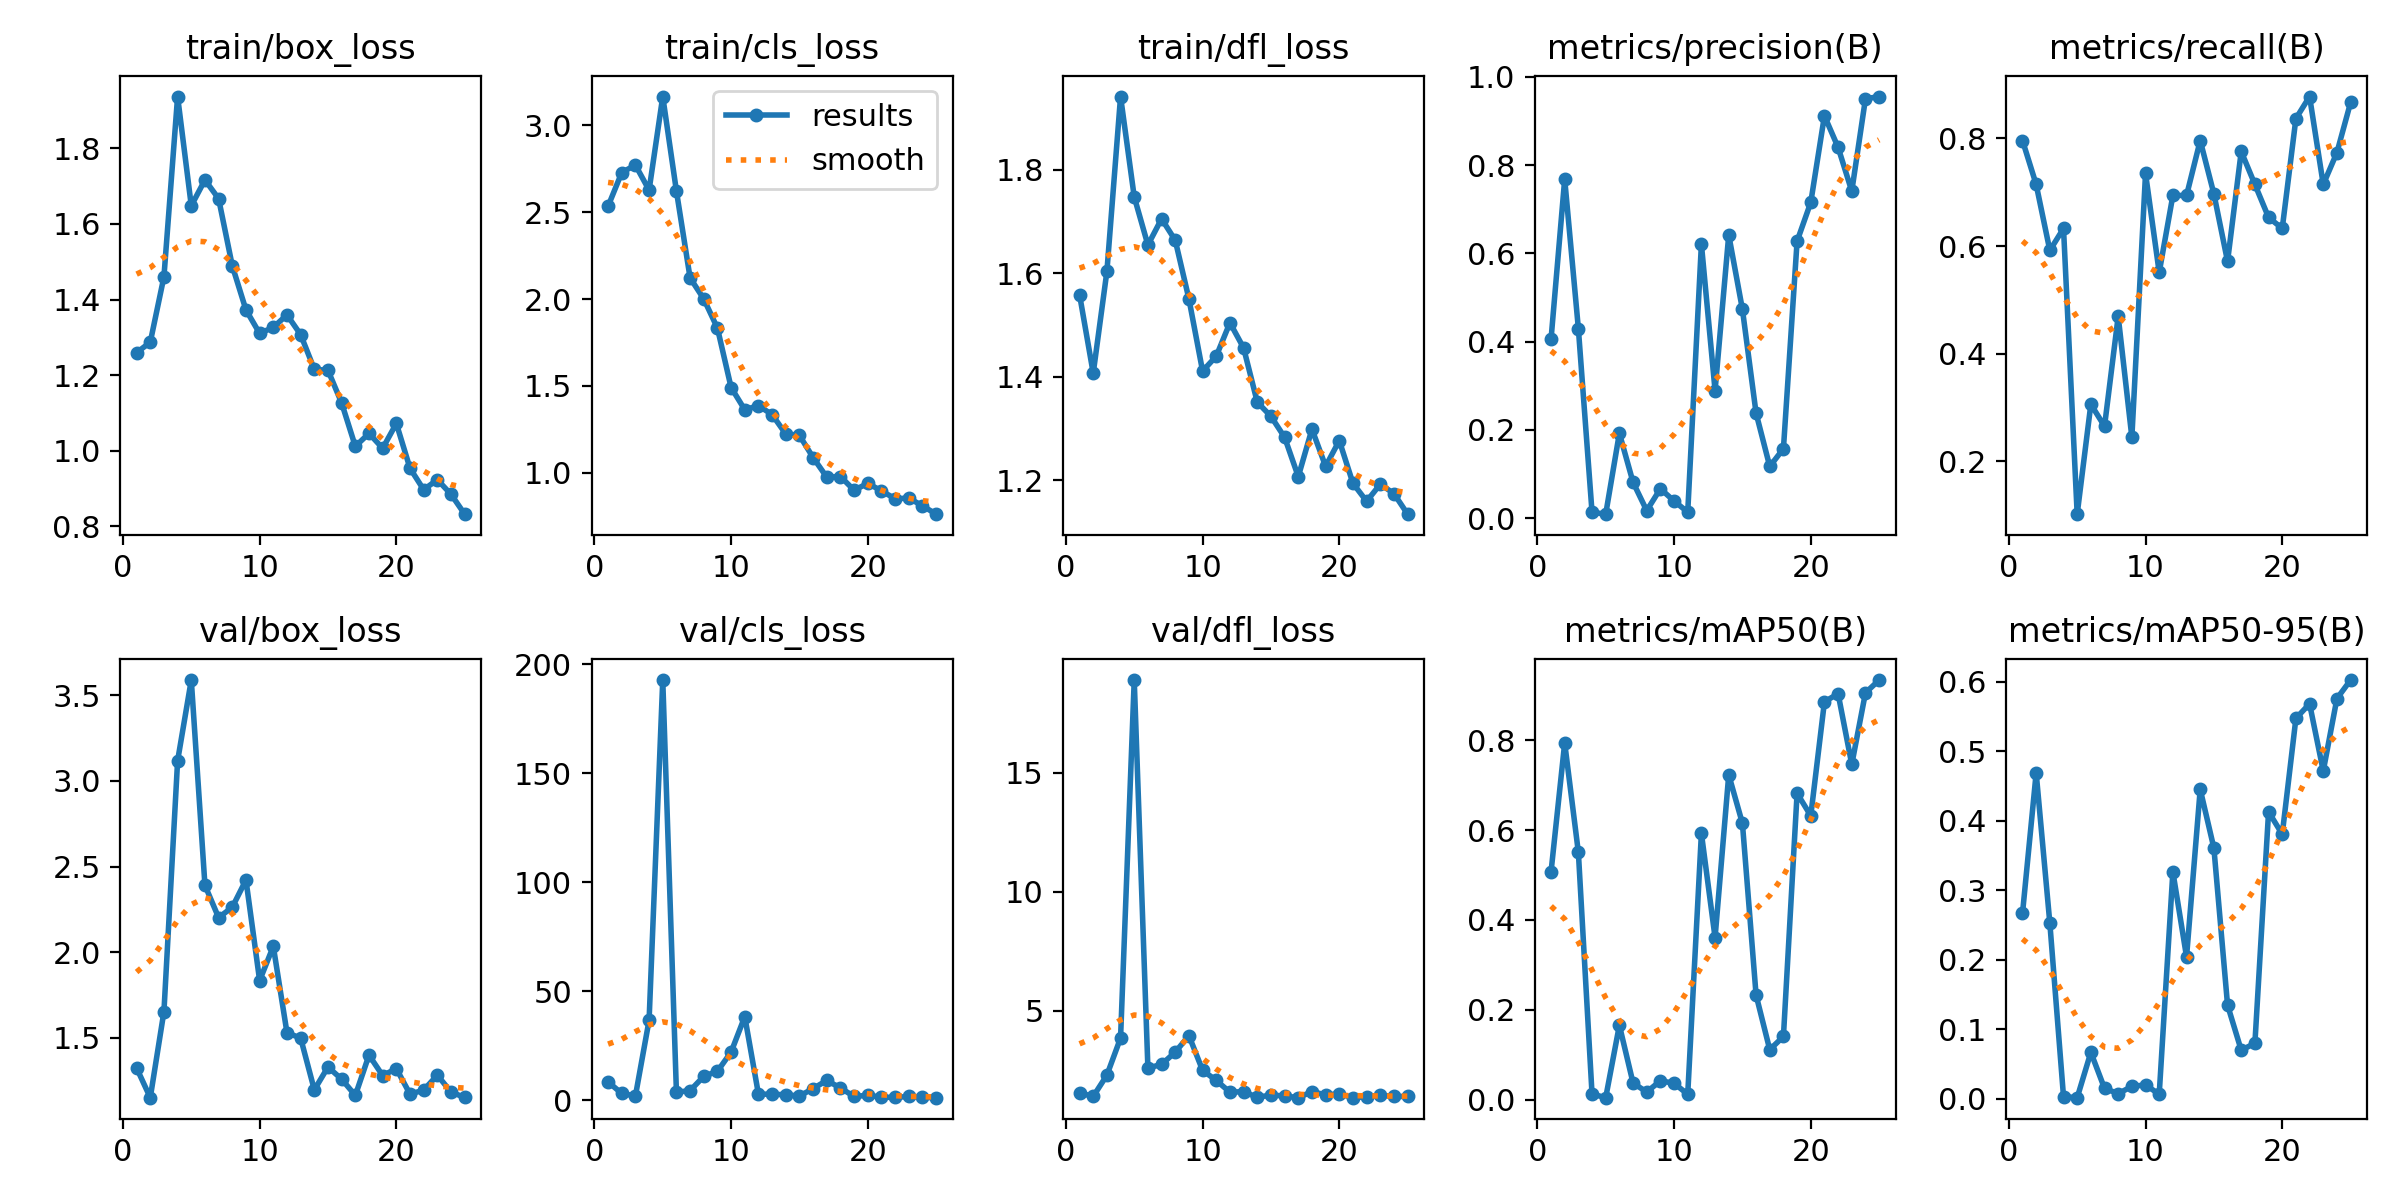

In [33]:
from IPython.display import Image

Image(filename=f'/home/jovyan/yolo-training/train5/results.png', width=1000)

In [34]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

ds.classes

['face']

In [35]:
from supervision.metrics import MeanAveragePrecision

model = YOLO(f'/home/jovyan/yolo-training/train5/weights/best.pt')

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

In [36]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.5724254682644205
mAP 50 0.9060455011018342
mAP 75 0.641629161436786


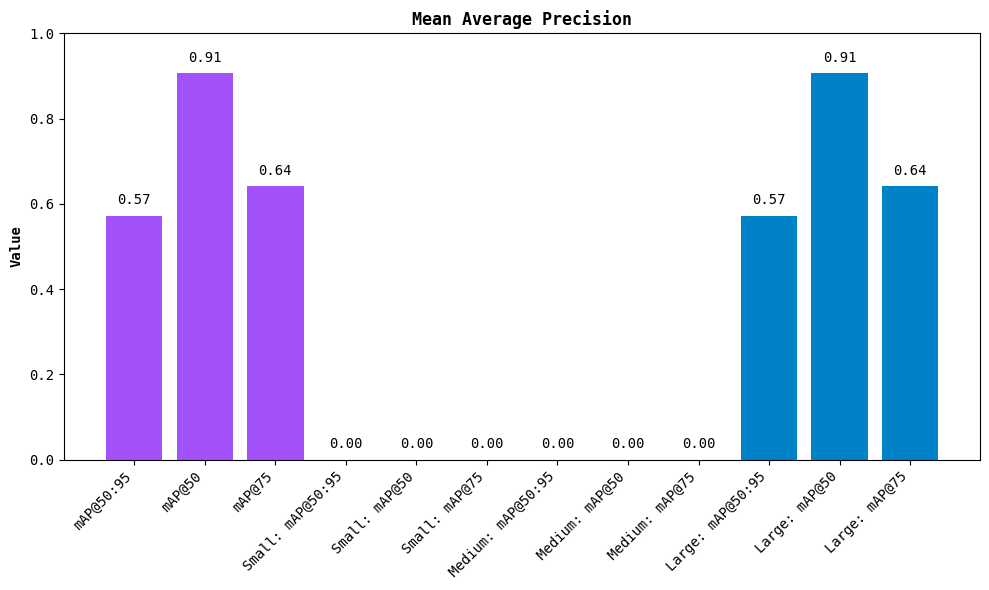

In [37]:
map.plot()

📈 Tes métriques actuelles
Metric	Score	Analyse rapide
mAP@50	0.906 ✅	Excellent → ton modèle détecte bien les objets cibles avec une bonne couverture générale.
mAP@75	0.642 ✅	Bon → ton modèle génère des boîtes bien ajustées dans une majorité de cas.
mAP@50:95	0.572 ✅	Correct à bon → ton modèle reste précis sur plusieurs seuils IoU, ce qui indique une généralisation correcte mais encore améliorable.

🧠 Ce que ça signifie concrètement
📦 Ton modèle repère efficacement les objets, même s’il reste quelques erreurs sur les contours ou dans des cas difficiles.

🧠 Il généralise bien, donc il est probablement apte à détecter des objets sur des images encore jamais vues (même domaine).

🔍 L’amélioration par rapport à avant (0.40 → 0.57 en mAP50:95) montre que tes récents changements sont efficaces.





## Run inference with fine-tuned YOLO model

In [38]:
import supervision as sv

model = YOLO(f'/home/jovyan/yolo-training/train5/weights/best.pt')

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

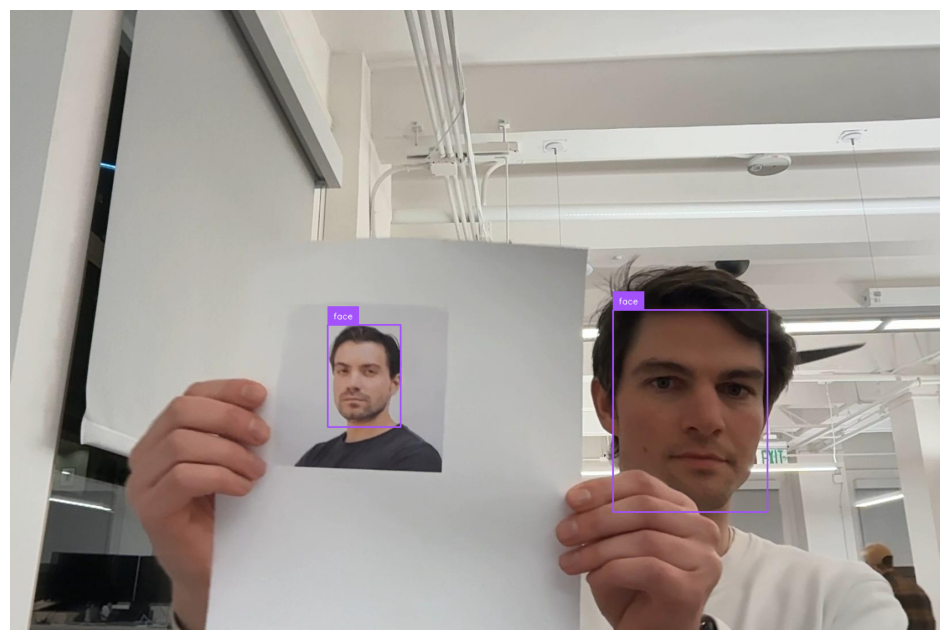

In [42]:
import random

i = random.randint(0, len(ds))

image_path, image, target = ds[i]

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

--2025-06-21 11:58:23--  https://github.com/laurent-pereira/ia-face-detector/blob/master/example.jpg?raw=true
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/laurent-pereira/ia-face-detector/raw/refs/heads/master/example.jpg [following]
--2025-06-21 11:58:23--  https://github.com/laurent-pereira/ia-face-detector/raw/refs/heads/master/example.jpg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/laurent-pereira/ia-face-detector/refs/heads/master/example.jpg [following]
--2025-06-21 11:58:23--  https://raw.githubusercontent.com/laurent-pereira/ia-face-detector/refs/heads/master/example.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (

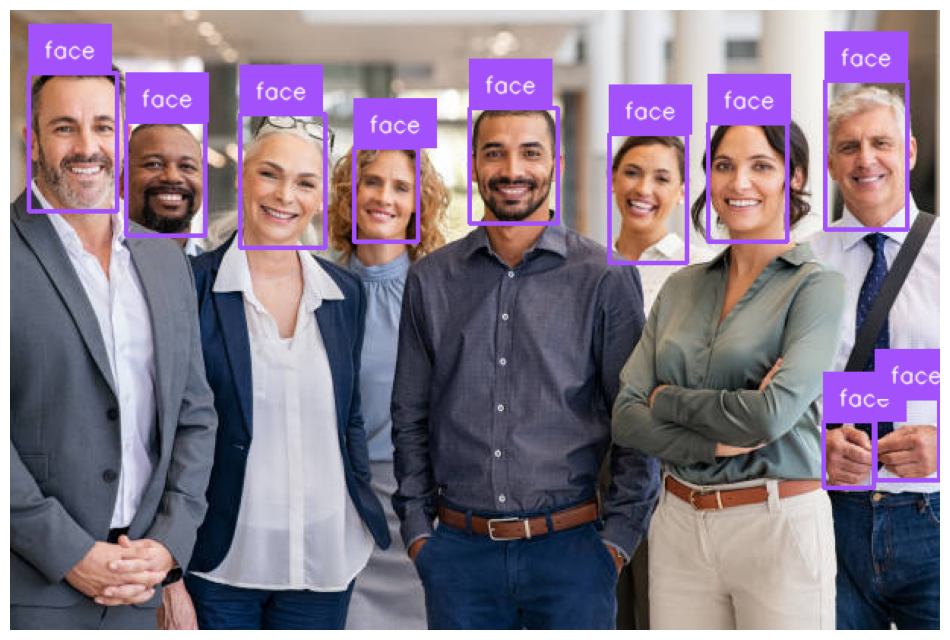

In [44]:
model = YOLO(f'/home/jovyan/yolo-training/train5/weights/best.pt')

!wget https://github.com/laurent-pereira/ia-face-detector/blob/master/example.jpg?raw=true

image_path = f"{HOME}/example.jpg?raw=true"
image = cv2.imread(image_path)

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)